In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [35]:
# Load Dataset
data = pd.read_csv("train_snli.txt", sep="\t", names=["text1", "text2", "label"])
data['text2'] = data['text2'].fillna('')  # Fill NaN in 'text2'
data.head()

,text1,text2,label
0,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",0
1,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",1
2,Children smiling and waving at camera,There are children present,1
3,Children smiling and waving at camera,The kids are frowning,0
4,A boy is jumping on skateboard in the middle o...,The boy skates down the sidewalk.,0


In [10]:
data.isnull().sum() 

text1    0
text2    0
label    0
dtype: int64

In [11]:
# Data Preprocessing
data['text1'] = data['text1'].str.lower().str.replace(r'[^a-z\s]', '', regex=True)
data['text2'] = data['text2'].str.lower().str.replace(r'[^a-z\s]', '', regex=True)

In [14]:
data.head()

,text1,text2,label
0,a person on a horse jumps over a broken down a...,a person is at a diner ordering an omelette,0
1,a person on a horse jumps over a broken down a...,a person is outdoors on a horse,1
2,children smiling and waving at camera,there are children present,1
3,children smiling and waving at camera,the kids are frowning,0
4,a boy is jumping on skateboard in the middle o...,the boy skates down the sidewalk,0


In [23]:
# Calculate the value counts for each class
class_counts = data['label'].value_counts()
print(class_counts)

# Check for class imbalance
total_samples = len(data)
for label, count in class_counts.items():
    percentage = (count / total_samples) * 100
    print(f"Class {label}: {count} samples ({percentage:.2f}%)")

label
0    183966
1    183407
Name: count, dtype: int64
Class 0: 183966 samples (50.08%)
Class 1: 183407 samples (49.92%)


In [24]:
# Feature Engineering
vectorizer = TfidfVectorizer(max_features=50000)
tfidf_text1 = vectorizer.fit_transform(data['text1'])
tfidf_text2 = vectorizer.transform(data['text2'])

In [25]:
# Cosine Similarity Feature
cosine_similarities = [
    cosine_similarity(tfidf_text1[i], tfidf_text2[i])[0][0] for i in range(tfidf_text1.shape[0])
]

In [26]:
# Combine Features
import scipy.sparse as sp
features = sp.hstack([tfidf_text1, tfidf_text2, sp.csr_matrix(cosine_similarities).T])

In [27]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(features, data['label'], test_size=0.2, random_state=42)


In [28]:
# Train Model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [29]:
# Evaluate Model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7964477713507996
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.78      0.79     36795
           1       0.79      0.81      0.80     36680

    accuracy                           0.80     73475
   macro avg       0.80      0.80      0.80     73475
weighted avg       0.80      0.80      0.80     73475



In [34]:
# Test with Custom Input
sample_text1 = "Two blond women are hugging one another."
sample_text2 = "The women are sleeping."
sample_vector1 = vectorizer.transform([sample_text1])
sample_vector2 = vectorizer.transform([sample_text2])
sample_cosine = cosine_similarity(sample_vector1, sample_vector2)[0][0]
sample_features = sp.hstack([sample_vector1, sample_vector2, sp.csr_matrix([sample_cosine])])

sample_prediction = model.predict(sample_features)
print(f"Prediction: {'Plagiarized' if sample_prediction[0] == 1 else 'Not Plagiarized'}")

Prediction: Not Plagiarized


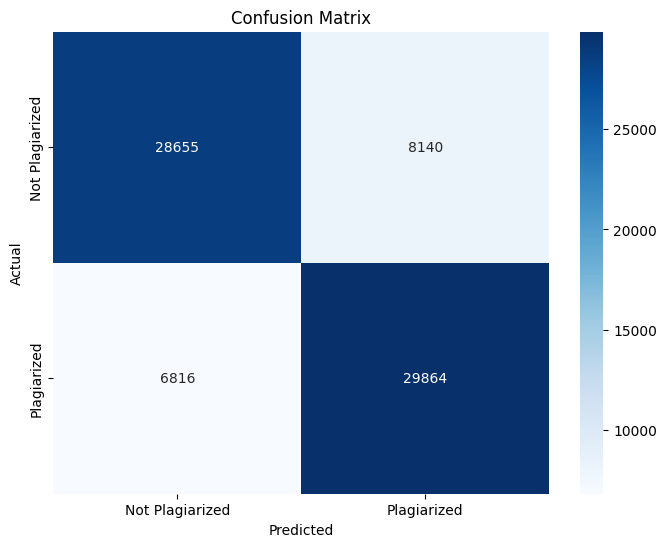

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Not Plagiarized', 'Plagiarized'],
            yticklabels=['Not Plagiarized', 'Plagiarized'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [36]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, log_loss

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for positive class (1)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report (Precision, Recall, F1-Score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Log Loss
logloss = log_loss(y_test, y_pred_proba)
print(f"\nLog Loss: {logloss:.4f}")


Accuracy: 0.7964

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.78      0.79     36795
           1       0.79      0.81      0.80     36680

    accuracy                           0.80     73475
   macro avg       0.80      0.80      0.80     73475
weighted avg       0.80      0.80      0.80     73475


Confusion Matrix:
[[28655  8140]
 [ 6816 29864]]

ROC-AUC Score: 0.8777

Log Loss: 0.4616
